In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"
print(f"Using device = {device}")

Using device = mps


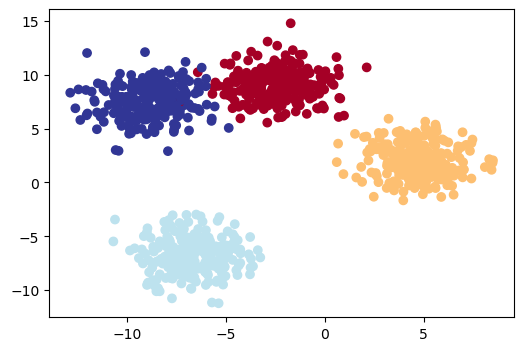

In [3]:
NUM_CLASSES =  4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

X = torch.from_numpy(X_blob).type(torch.float)
y = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(6, 4))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap='RdYlBu');

In [4]:
#Build a model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [5]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [6]:
model_1 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.05)

In [8]:
model_1.eval()
with torch.inference_mode():
    y_logits = model_1(X_test.to(device))

y_logits[:10]

tensor([[ 0.6555,  0.4934,  0.1690, -0.3989],
        [-0.2317,  0.0098, -0.4045,  0.2141],
        [ 0.5407,  0.3172,  0.0580, -0.3581],
        [ 0.3307,  0.1708, -0.0092, -0.2170],
        [ 0.7450,  0.5666,  0.3312, -0.6875],
        [-0.3219,  0.0197, -0.4974,  0.3087],
        [ 0.6073,  0.3961,  0.0873, -0.3645],
        [ 0.4635,  0.3630,  0.1697, -0.5127],
        [ 0.4160,  0.2938, -0.1143, -0.1703],
        [ 0.5353,  0.4092,  0.2095, -0.5675]], device='mps:0')

In [9]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([0, 3, 0, 0, 0, 3, 0, 0, 0, 0], device='mps:0')

In [10]:
epochs = 3000
torch.manual_seed(42)
trainLossList = []
testLossList = []
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass 
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Compute training loss
    loss = loss_fn(y_logits, y_train)

    # 3. Zero grad the optimizer
    optimizer.zero_grad()

    # 4. Loss backward -> backpropagate
    loss.backward()

    #5. Step the optimizer
    optimizer.step()

    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
    
    if epoch%10 == 0:
        print(f"Epoch: {epoch}| Train Loss: {loss:.4f}| Train Acc: {acc}| Test Loss: {test_loss:.4f}| Test Acc: {test_acc}")

    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

Epoch: 0| Train Loss: 1.2637| Train Acc: 40.125| Test Loss: 1.2086| Test Acc: 51.5
Epoch: 10| Train Loss: 1.0379| Train Acc: 47.375| Test Loss: 0.9995| Test Acc: 52.0
Epoch: 20| Train Loss: 0.9145| Train Acc: 68.25| Test Loss: 0.8762| Test Acc: 70.5
Epoch: 30| Train Loss: 0.7733| Train Acc: 73.5| Test Loss: 0.7399| Test Acc: 73.0
Epoch: 40| Train Loss: 0.6135| Train Acc: 74.25| Test Loss: 0.5951| Test Acc: 73.5
Epoch: 50| Train Loss: 0.5021| Train Acc: 76.625| Test Loss: 0.4966| Test Acc: 75.5
Epoch: 60| Train Loss: 0.4348| Train Acc: 82.875| Test Loss: 0.4339| Test Acc: 81.5
Epoch: 70| Train Loss: 0.3883| Train Acc: 88.625| Test Loss: 0.3885| Test Acc: 87.5
Epoch: 80| Train Loss: 0.3524| Train Acc: 93.5| Test Loss: 0.3525| Test Acc: 93.5
Epoch: 90| Train Loss: 0.3227| Train Acc: 96.5| Test Loss: 0.3225| Test Acc: 98.5
Epoch: 100| Train Loss: 0.2970| Train Acc: 98.75| Test Loss: 0.2962| Test Acc: 99.5
Epoch: 110| Train Loss: 0.2740| Train Acc: 99.0| Test Loss: 0.2727| Test Acc: 99.5
Ep

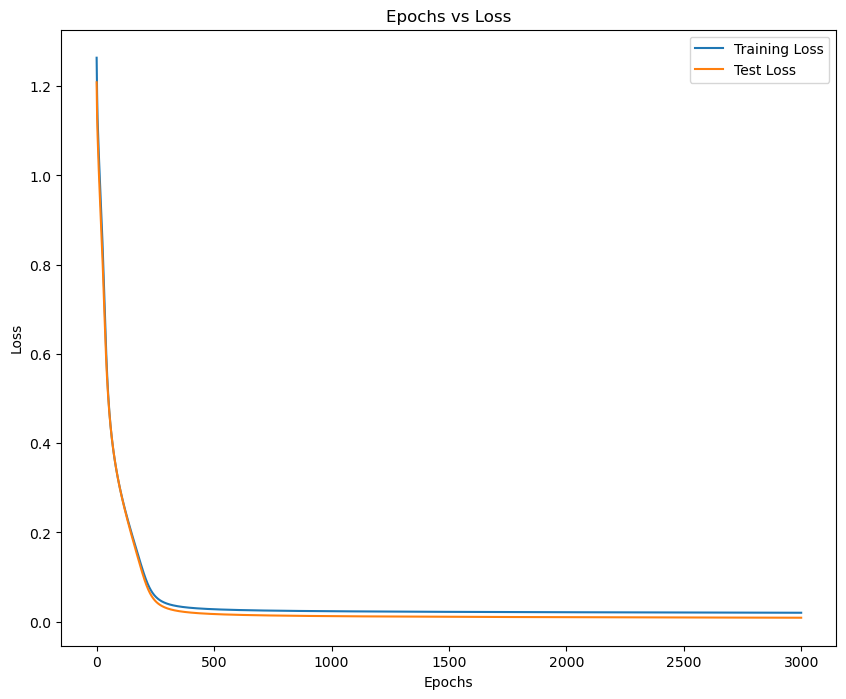

In [11]:
# Plot Loss Curve
plt.figure(figsize=(10,8))
plt.plot(range(epochs), trainLossList, label="Training Loss")
plt.plot(range(epochs), testLossList, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend();

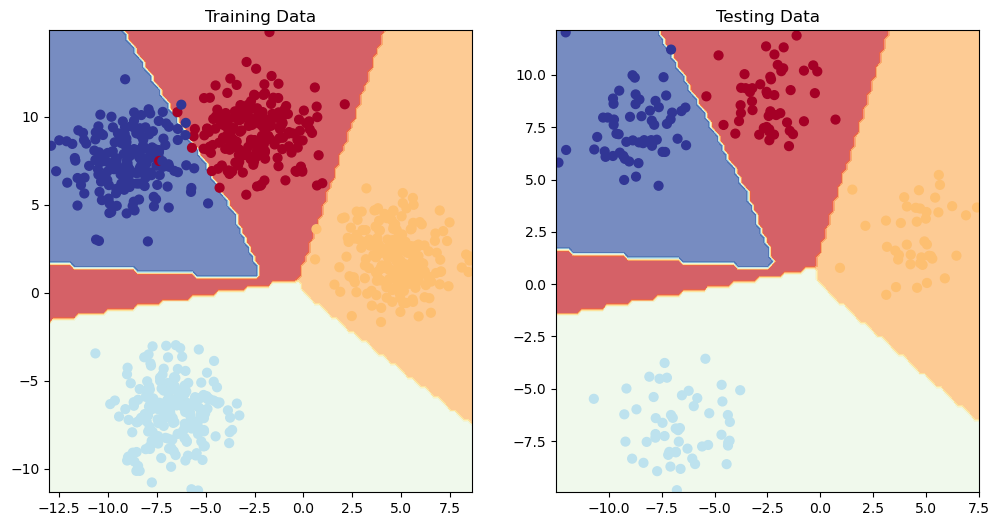

In [12]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Training Data")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing Data")
plot_decision_boundary(model_1, X_test, y_test)